# Build A QA System over SQL Data
[build a QA system over sql data](https://python.langchain.com/docs/tutorials/sql_qa/)

> Prerequisite knowledge: <br>
> [chat model](https://python.langchain.com/docs/concepts/chat_models/)、[Tools](https://python.langchain.com/docs/concepts/tools/)、[Agent](https://python.langchain.com/docs/concepts/agents/)、[LangGraph](https://python.langchain.com/docs/concepts/architecture/#langgraph)

本节将介绍两种通过数据库中的表格数据创建QA系统的基本方法：
- **Chains**: 按照 “生成查询语句 --> 执行查询 --> 生成答案” 的流程进行。并尝试在执行查询之前加入中断操作，人为判断后再执行接下来的步骤（即人工审核查询语句是否合法、正确）。其中还简单使用了一下**模型的结构化输出**
- **Agents**: 仍然使用 `create_react_agent` 来构建Agent。其中的工具部分，使用 `SQLDatabaseToolkit` 提供的各种工具，允许agent调用不同工具直到获得答案。另外，针对一些专有名词，为它们构建了一个向量数据库，并把数据库的检索器包装为工具，并补充原来的 `prompt` ，由此针对部分专有名词实现简单的“模糊搜索”

二者的区别在于后者可以在数据库中任意查询多次知道找到答案，而前者只能按照预设的步骤进行

> ⚠️ 注意 ⚠️<br>
> 构建一个模型驱动的系统可能会给数据库带来风险。因此，请确保使用权限尽可能狭窄。更多的与安全有关的实践[请看这里](https://python.langchain.com/docs/security/)

系统构建的步骤：
1. 使用模型把问题转化为SQL查询语句
2. 在数据库中执行查询
3. 模型根据查询结构回答问题

如果数据存储在csv文件，有更简单的查询方法： [how to do QA over CSVs](https://python.langchain.com/docs/how_to/sql_csv/)

## Setup

关于数据库，官方给出了[官方下载教程]("D:\PersonalLearning\20250926_LangChian\langchain\tutorial\Chinook.db")。这里由于本人本身就有 Navicat ，不想下载新的，因此直接在 Navicat 新建了个 SQLite 数据库连接，把数据导入进去了

> 它给出的 sql 脚本( 从 github 下载)，导入的时候发现有一半的连接失败了...没有去找什么原因，反正暂时不影响练习......

In [2]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///D:/PersonalLearning/20250926_LangChian/langchain/tutorial/Chinook.db")

print(db.dialect)                  # sqlite
print(db.get_usable_table_names()) # ['Album', 'Artist', 'Track', ...]
print(db.run("SELECT * FROM Artist LIMIT 10;"))


sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']
[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]


## Chains

在 LangGraph 中，chains 可以由简单的 nodes 的序列表示

### application state

In [3]:
from typing_extensions import TypedDict

class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

### 1. convert question to SQL query

In [4]:
import os
from langchain.chat_models import init_chat_model

os.environ.get('GOOGLE_API_KEY')
os.environ['HTTP_PROXY'] = 'http://127.0.0.1:7890'
os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:7890'

llm = init_chat_model("gemini-2.5-flash", model_provider='google-genai')

`tabel_info`： 这里指的是 `db.get_table_info()` 得到的是数据库中表的**建表语句 + 字段信息 + 示例行**，是连接 LLM 与数据库的桥梁

In [5]:
from langchain_core.prompts import ChatPromptTemplate

system_message = """
Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}
"""

user_prompt = "Question: {input}"

query_prompt_template = ChatPromptTemplate(
    [('system', system_message), ('user', user_prompt)]
)

for message in query_prompt_template.messages:
    message.pretty_print()

================================ System Message ================================


Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}

================================ Human Message =================================

Question: {input}


**模型的结构化输出：**`llm.with_structed_output(QueryOutput)` ，其中 `llm` 是聊天模型，`QueryOutput` 是自定义的 `TypeDict` 类对象

**注意：** 模型的结构化输出，需要使用的模型支持结构化输出才行

In [8]:
from typing_extensions import Annotated

class QueryOutput(TypedDict):
    """generated SQL query"""
    query: Annotated[str, ..., 'Syntactically vaild SQL query.']


def write_query(state: State):
    """generate SQL query to fetch information"""
    prompt = query_prompt_template.invoke({
        'dialect': db.dialect,
        'top_k': 10,
        'table_info': db.get_table_info(),
        'input': state['question'],
    })
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result['query']}

In [9]:
write_query({'question': 'how many employees are there?'})

{'query': 'SELECT COUNT(EmployeeId) FROM Employee;'}

### 2. 执行查询

In [11]:
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool

def execute_query(state: State):
    """execute SQL query"""
    execute_query_tool = QuerySQLDataBaseTool(db=db)
    return {'result': execute_query_tool.invoke(state['query'])}

In [12]:
execute_query({'query': 'SELECT COUNT(EmployeeId) FROM Employee;'})

C:\Users\86136\AppData\Local\Temp\ipykernel_21148\3808080095.py:5: LangChainDeprecationWarning: The class `QuerySQLDataBaseTool` was deprecated in LangChain 0.3.12 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-community package and should be used instead. To use it run `pip install -U :class:`~langchain-community` and import as `from :class:`~langchain_community.tools import QuerySQLDatabaseTool``.
  execute_query_tool = QuerySQLDataBaseTool(db=db)


{'result': '[(8,)]'}

### 3. 生成答案

In [13]:
def generate_answer(state: State):
    """answer question using retrieved information as context"""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f"Question: {state['question']}\n"
        f"SQL Query: {state['query']}\n"
        f"SQL Result: {state['result']}"
    )
    response = llm.invoke(prompt)
    return {'answer': response.content}

### 4. 使用LangGraph编排

In [14]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, 'write_query')
graph = graph_builder.compile()

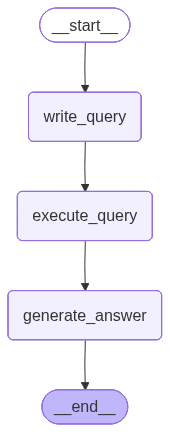

In [15]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
for step in graph.stream(
    {"question": "How many employees are there?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': 'SELECT COUNT(EmployeeId) FROM Employee;'}}
{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': 'There are 8 employees.'}}


### human-in-loop

为了在敏感步骤（如执行SQL查询）之前中断应用程序，以便进行人工审核。( 运行的进度将保存到自己选择的存储中，这里我们指定内存存储 )

In [17]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory, interrupt_before=['execute_query'])

# Now that we're using persistence, we need to specify a thread ID
# so that we can continue the run after review.
config = {"configurable": {"thread_id": "1"}}

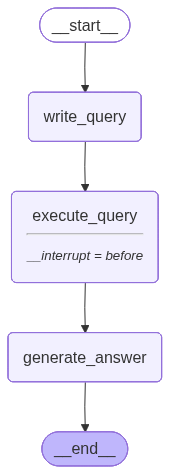

In [18]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
for step in graph.stream(
    {"question": "How many employees are there?"},
    config,
    stream_mode="updates",
):
    print(step)

try:
    user_approval = input("Do you want to go to execute query? (yes/no): ")
except Exception:
    user_approval = "no"

if user_approval.lower() == "yes":
    # If approved, continue the graph execution
    for step in graph.stream(None, config, stream_mode="updates"):
        print(step)
else:
    print("Operation cancelled by user.")

{'write_query': {'query': 'SELECT COUNT(EmployeeId) FROM Employee;'}}
{'__interrupt__': ()}
{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': 'There are 8 employees.'}}


### 扩展

对于更多复杂的查询生成，可能需要使用 *few-shot prompts* 或者增加 *查询检查* 点击下列连接来查看类似的先进技术 ( 在基于SQL进行QA方面 )：
- [Prompting strategies](https://python.langchain.com/docs/how_to/sql_prompting/): 高级的提示词工程技术
- [Query checking](https://python.langchain.com/docs/how_to/sql_query_checking/): 添加查询验证和错误处理
- [Large databases](https://python.langchain.com/docs/how_to/sql_large_db/): 处理更大型的数据库的技术

## Agents

与chains方法相比，Agents的行为要更加不可预测，但具有以下优势：
- 多次执行查询来回答用户问题
- 通过运行生成的查询、捕捉回溯并正确地重新生成查询来恢复错误。
- 回答基于数据库模式和数据库内容（如描述特定表）的问题。

`SQLDatabaseToolkit` 可以生成和执行查询、检查查询语法、检索表描述...

In [20]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()

tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001EFA81E8A00>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001EFA81E8A00>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001EFA81E8A00>),
 QuerySQLCheckerTool(description='Use this tool to 

### system prompt

In [21]:
system_message = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

You MUST double check your query before executing it. If you get an error while
executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the
database.

To start you should ALWAYS look at the tables in the database to see what you
can query. Do NOT skip this step.

Then you should query the schema of the most relevant tables.
""".format(
    dialect="SQLite",
    top_k=5,
)

### agent 初始化

In [22]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, tools, prompt=system_message)

In [23]:
question = "Which country's customers spent the most?"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which country's customers spent the most?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (723088c6-f764-492d-917e-f389f5d574d8)
 Call ID: 723088c6-f764-492d-917e-f389f5d574d8
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (cdc947cb-ab6d-4d3e-a0c3-8685f3fca774)
 Call ID: cdc947cb-ab6d-4d3e-a0c3-8685f3fca774
  Args:
    table_names: Customer, Invoice
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Customer" (
	"CustomerId" INTEGER NOT NULL, 
	"FirstName" NVARCHAR(40) NOT NULL, 
	"LastName" NVARCH

In [24]:
question = "Describe the playlisttrack table"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Describe the playlisttrack table
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (9dfc09f6-10cf-44d6-be40-53aa55c3fe78)
 Call ID: 9dfc09f6-10cf-44d6-be40-53aa55c3fe78
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (acc7d7d6-aed1-49b3-848b-fd8409d10382)
 Call ID: acc7d7d6-aed1-49b3-848b-fd8409d10382
  Args:
    table_names: PlaylistTrack
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "PlaylistTrack" (
	"PlaylistId" INTEGER NOT NULL, 
	"TrackId" INTEGER NOT NULL, 
	PRIMARY KEY ("PlaylistId", "Trac

### dealing with high-cardinaliity columns

有一些包含专有名词的列，如地址、歌曲名、人名等。如果直接执行查询，可能不支持类似“模糊搜素”的功能。例如，如果数据库存储的是"Alice"，而用户输入"alice"可能会查询失败。

为此，可以通过创建一个具有数据库中所有专有名词的向量存储来实现这一目标。在每次用户输入包含专有名词时，在矢量存储中查询，以找到单词的正确拼写。

收集专有名词

In [25]:
import ast
import re

def query_as_list(db, query):
    res = db.run(query)
    res = [el for sub in ast.literal_eval(res) for el in sub if el]
    res = [re.sub(r"\b\d+\b", "", string).strip() for string in res]
    return list(set(res))

artists = query_as_list(db, "SELECT Name FROM Artist")
albums = query_as_list(db, "SELECT Title FROM Album")
albums[:5]

['How To Dismantle An Atomic Bomb',
 'The Best of Ed Motta',
 'Instant Karma: The Amnesty International Campaign to Save Darfur',
 'South American Getaway',
 'Led Zeppelin III']

In [30]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2",
    cache_folder='./embedding_model')

d:\DevTools\miniconda3\envs\langchain\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\DevTools\miniconda3\envs\langchain\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in D:\PersonalLearning\20250926_LangChian\langchain\tutorial\embedding_model\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to

In [31]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

> 这里解释一下为什么不直接使用 `retriever` 作为 `tool`：<br>
> 
> `retriever` ：是一个接口( `BaseRetriever` )，是一个纯功能组件，不会有名字、描述，也没有标准化的输入输出模型。虽然能在通过手写代码 ( `Chains` ) 中作为工具使用，但是在 `Agent` 中无法被识别为工具<br>
> 因此需要使用 `create_retriever_tool` 对它进行包装

In [ ]:
from langchain.agents.agent_toolkits import create_retriever_tool

_ = vector_store.add_texts(artists + albums)
retriever = vector_store.as_retriever(search_kwargs={'k': 5})  # 把向量数据库内容包装为一个检索器接口
# retriever.get_relevant_documents('Alice Chains')
description = (
    "Use to look up values to filter on. Input is an approximate spelling "
    "of the proper noun, output is valid proper nouns. Use the noun most "
    "similar to the search."
)
retriever_tool = create_retriever_tool(  # 把检索器包装为一个tool
    retriever,
    name='search_proper_nouns',
    description=description  # 给 LLM 的工具描述
)

In [33]:
print(retriever_tool.invoke('Alice Chains'))

Alice In Chains

Iron Maiden

Iron Maiden

Black Sabbath

Black Sabbath


In [34]:
# Add to system message
suffix = (
    "If you need to filter on a proper noun like a Name, you must ALWAYS first look up "
    "the filter value using the 'search_proper_nouns' tool! Do not try to "
    "guess at the proper name - use this function to find similar ones."
)
system = f"{system_message}\n\n{suffix}"

tools.append(retriever_tool)

agent = create_react_agent(llm, tools, prompt=system)

In [35]:
question = "How many albums does alis in chain have?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

How many albums does alis in chain have?
================================== Ai Message ==================================
Tool Calls:
  search_proper_nouns (8317e6d9-866d-4994-8bb2-2e781f0f98af)
 Call ID: 8317e6d9-866d-4994-8bb2-2e781f0f98af
  Args:
    query: alis in chain
================================= Tool Message =================================
Name: search_proper_nouns

Aisha Duo

Habib Koité and Bamada

Warner  Anos

A-Sides

In Step
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (e2fc6f9c-de30-4efb-93bf-f067c9eb8eb8)
 Call ID: e2fc6f9c-de30-4efb-93bf-f067c9eb8eb8
  Args:
    tool_input:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================